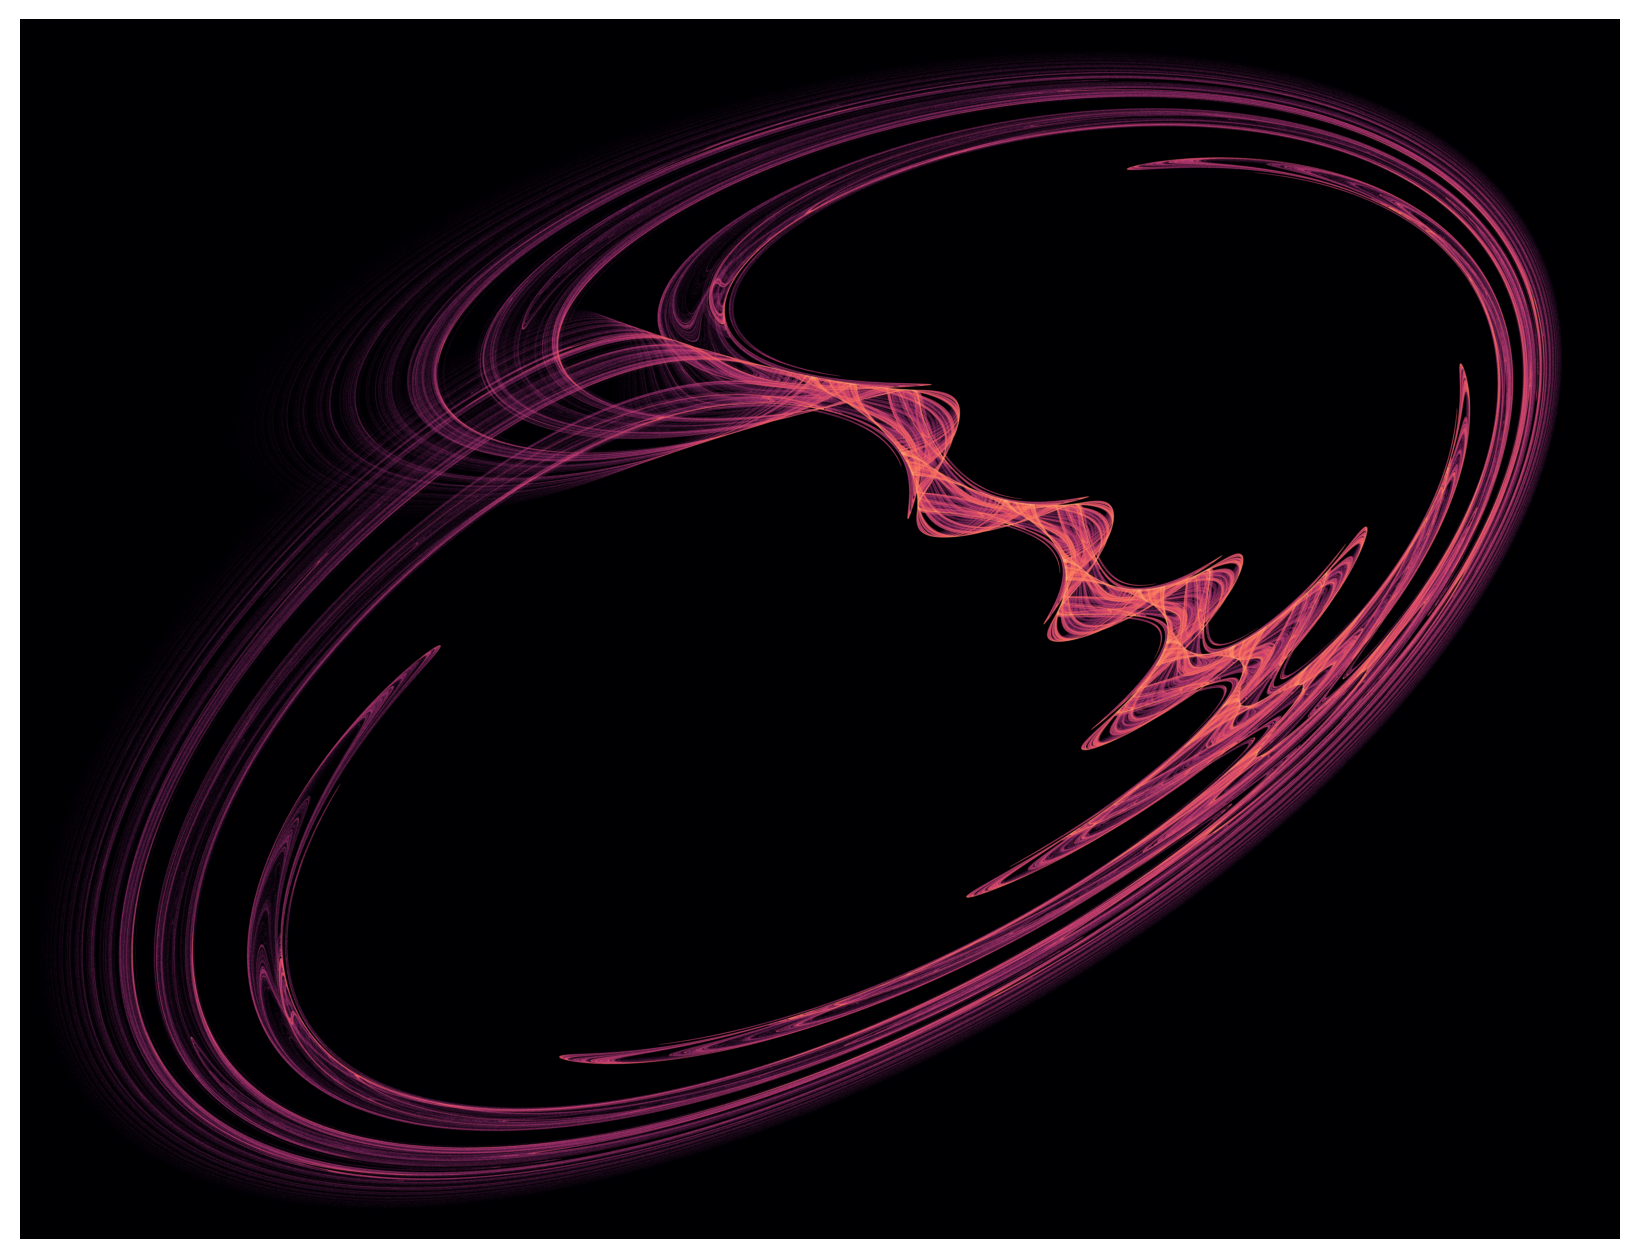

a0..a11 = [-0.1  0.8 -0.7 -1.1 -1.1 -0.7 -0.4  0.6 -0.6 -0.3  1.2  0.6]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from numba import njit
    NUMBA = True
except Exception:
    NUMBA = False

ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXY"
VALUES = {ch: -1.2 + 0.1*i for i, ch in enumerate(ALPHABET)}

def decode_code(code: str) -> np.ndarray:
    code = code.strip().upper()
    if len(code) != 12:
        raise ValueError("Parameter code must have 12 letters (A..Y).")
    try:
        return np.array([VALUES[c] for c in code], dtype=np.float64)
    except KeyError as e:
        raise ValueError(f"Invalid letter {e.args[0]!r}; only A..Y are allowed.") from None

def step(x, y, a):
    x_next = a[0] + a[1]*x + a[2]*x*x + a[3]*x*y + a[4]*y + a[5]*y*y
    y_next = a[6] + a[7]*x + a[8]*x*x + a[9]*x*y + a[10]*y + a[11]*y*y
    return x_next, y_next

def estimate_bounds(a, N=200_000, burn=2_000, x0=0.1, y0=0.1, clip=1e-3):
    """Run a short orbit to get robust bounds for the histogram window."""
    xs = np.empty(N, dtype=np.float64)
    ys = np.empty(N, dtype=np.float64)
    x, y = x0, y0
    for n in range(N + burn):
        x, y = step(x, y, a)
        if n >= burn:
            i = n - burn
            xs[i] = x; ys[i] = y
    xmin, xmax = np.quantile(xs, [clip, 1-clip])
    ymin, ymax = np.quantile(ys, [clip, 1-clip])
    # small padding
    dx = 0.05*(xmax - xmin); dy = 0.05*(ymax - ymin)
    return xmin - dx, xmax + dx, ymin - dy, ymax + dy

if NUMBA:
    @njit(fastmath=True, cache=True)
    def accumulate_hist(a, x0, y0, xmin, xmax, ymin, ymax, bins, n_iter, burn):
        H = np.zeros((bins, bins), np.uint32)
        x, y = x0, y0
        sx = (bins - 1.0) / (xmax - xmin)
        sy = (bins - 1.0) / (ymax - ymin)
        for i in range(n_iter):
            x, y = (
                a[0] + a[1]*x + a[2]*x*x + a[3]*x*y + a[4]*y + a[5]*y*y,
                a[6] + a[7]*x + a[8]*x*x + a[9]*x*y + a[10]*y + a[11]*y*y,
            )
            if i >= burn:
                ix = int((x - xmin) * sx)
                iy = int((y - ymin) * sy)
                if 0 <= ix < bins and 0 <= iy < bins:
                    H[ix, iy] += 1
        return H
else:
    def accumulate_hist(a, x0, y0, xmin, xmax, ymin, ymax, bins, n_iter, burn):
        H = np.zeros((bins, bins), np.uint32)
        x, y = x0, y0
        sx = (bins - 1.0) / (xmax - xmin)
        sy = (bins - 1.0) / (ymax - ymin)
        for i in range(n_iter):
            x, y = step(x, y, a)
            if i >= burn:
                ix = int((x - xmin) * sx)
                iy = int((y - ymin) * sy)
                if 0 <= ix < bins and 0 <= iy < bins:
                    H[ix, iy] += 1
        return H

def render_polynomial(code="FIRCDERRPVLD",
                      n_iter=5_000_000, burn=5_000,
                      bins=2048, gamma=0.7,
                      x0=0.1, y0=0.1, clip=1e-3,
                      cmap="magma"):
    """
    Render a polynomial (quadratic) attractor.

    Parameters
    ----------
    code   : 12-letter code (A..Y). Example: "FIRCDERRPVLD".
    n_iter : total iterations (increase for crisper detail).
    burn   : iterations discarded as transient.
    bins   : histogram resolution (e.g., 1024..4096).
    gamma  : tone curve for log-density image (lower -> brighter filaments).
    x0,y0  : initial point.
    clip   : quantile clipping when estimating bounds.
    cmap   : matplotlib colormap.
    """
    a = decode_code(code)
    xmin, xmax, ymin, ymax = estimate_bounds(a, clip=clip, x0=x0, y0=y0)
    H = accumulate_hist(a, x0, y0, xmin, xmax, ymin, ymax,
                        bins=bins, n_iter=n_iter, burn=burn)

    D = np.log1p(H.astype(np.float64))
    D /= D.max() if D.max() > 0 else 1.0
    D = D**(1.0 - gamma)  # simple contrast curve

    # Plot
    fig = plt.figure(figsize=(8, 8), dpi=200, facecolor="white")
    ax = plt.axes([0,0,1,1], frameon=False)  # clean borderless canvas
    ax.axis("off")
    ax.imshow(D.T, origin="lower",
              extent=(xmin, xmax, ymin, ymax),
              interpolation="bilinear", cmap=cmap)
    plt.savefig("attractor") 
    plt.show()
    return a  # return coefficients for reference

coeffs = render_polynomial(code="LUFBBFISGJYS",
                           n_iter=100_000_000,  
                           burn=12_000,
                           bins=15_000,
                           gamma=0.65,
                           cmap="magma")
print("a0..a11 =", coeffs.round(3))